<a href="https://colab.research.google.com/github/aneeshc12/CV-A3/blob/main/2020111018_CV_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install and import
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Q1


In [18]:
# declare hyperparameters
batchSize = 64
numClasses = 10
lr = 0.001
numEpochs = 20

# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# import CIFAR-10 and create torch dataloaders
allTransforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                      # cifar 10 mean and std found online
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])

# declare datasets
trainDataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = allTransforms,
                                             download=True)

testDataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = False,
                                             transform = allTransforms,
                                             download=True)

# dataloaders
trainLoader = torch.utils.data.DataLoader(trainDataset,
                                          batch_size=batchSize,
                                          shuffle=True)

testLoader = torch.utils.data.DataLoader(testDataset,
                                          batch_size=batchSize,
                                          shuffle=True)

"""
# trainx: 50000 x 32 x 32 x 3
# trainy: 50000 x 1

# testx: 10000 x 32 x 32 x 3
# testy: 10000 x 1
"""

cuda
Files already downloaded and verified
Files already downloaded and verified


'\n# trainx: 50000 x 32 x 32 x 3\n# trainy: 50000 x 1\n\n# testx: 10000 x 32 x 32 x 3\n# testy: 10000 x 1\n'

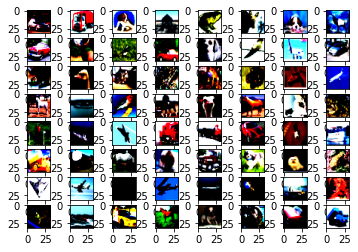

In [19]:
features, labels = next(iter(trainLoader))
for i, (img, label) in enumerate(zip(features, labels)):
  plt.subplot(8,8, i + 1)
  img = np.swapaxes(img, 0, 2)
  img = np.swapaxes(img, 0, 1)

  plt.imshow(img)

plt.show()

In [20]:
# main CNN class
class CNN(nn.Module):
  def __init__(self, numClasses=10):
    super(CNN, self).__init__()

    # images are 32x32x3

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    # 32x32x32

    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # 16x16x32


    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(1600, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, numClasses)

  def forward(self, x):
    # 64 x 3 x 32 x 32
    
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.maxPool1(out)

    # 64 x 32 x 14 x 14

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.maxPool2(out)

    # 64 x 64 x 5 x 5

    out = out.reshape(out.size(0), -1)
    # 64 X 1600

    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)

    # 64 x 10

    return out

In [26]:
# set up hyperparameters
model = CNN()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.005, momentum=0.9)

totalStep = len(trainLoader)

In [28]:
# train the CNN

def saveModel(model, epoch, path, loss):
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      }, path)
  
for epoch in range(numEpochs):
  for i, (images, labels) in enumerate(trainLoader):
    # shift to cuda
    images = images.to(device)
    labels = labels.to(device)

    # forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backwards and optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch [%d/%d], Loss: {:%.4f}' % (epoch+1, numEpochs, loss.item()))

  if epoch % 2 == 0:
    saveModel(model, epoch, "Q1_CNN_epoch_" + str(epoch), loss.item())

Epoch [1/20], Loss: {:1.4886}
Epoch [2/20], Loss: {:1.2171}
Epoch [3/20], Loss: {:0.9699}
Epoch [4/20], Loss: {:1.0066}
Epoch [5/20], Loss: {:1.0164}
Epoch [6/20], Loss: {:0.8850}
Epoch [7/20], Loss: {:0.8518}
Epoch [8/20], Loss: {:1.1218}
Epoch [9/20], Loss: {:0.8802}
Epoch [10/20], Loss: {:1.0982}
Epoch [11/20], Loss: {:0.6622}
Epoch [12/20], Loss: {:0.5570}
Epoch [13/20], Loss: {:0.8621}
Epoch [14/20], Loss: {:1.2531}
Epoch [15/20], Loss: {:0.3764}
Epoch [16/20], Loss: {:0.7285}
Epoch [17/20], Loss: {:0.6526}
Epoch [18/20], Loss: {:0.5048}
Epoch [19/20], Loss: {:0.6285}
Epoch [20/20], Loss: {:0.6830}


In [ ]:
# evaluate

In [33]:
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in trainLoader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    # max confidence value is the predicted class
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy on %d training images: %.3f" % (50000, 100 * float(correct)/total))

Accuracy on 50000 training images: 82.486
